In [2]:
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz 
import matplotlib.pyplot as plt
import pylab
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
import shap
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)

The dataset is from https://data.world/login?next=%2Fdata-society%2Fbank-marketing-data%2Fworkspace%2Ffile%3Ffilename%3Dbank-additional-names.txt and I have do some extra work by using excel for the data cleaning.

## Some extra data preprocessing

In [3]:
final_dataset = pd.read_excel('FINAL.xlsx')
final_dataset.head(2)

,age,age_group,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,High,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,High,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# see whether the dataset has NULL
final_dataset.isnull().sum()

age                  0
age_group            0
job                  0
marital              0
education            0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
is_contact_before    0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

we need to get the dummies of some of the features so we could see the name of the them and may get the importance of them in the models(past idea, now dropped)

In [5]:
raw_col_name = list(final_dataset.columns)
raw_col_name

['age',
 'age_group',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'is_contact_before',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [6]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown = 'ignore')

#perform one-hot encoding on 'age_group' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['age_group']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age = final_dataset.join(encoder_df)

raw_col_name.extend(['age_fundemental', 'age_high', 'age_middle', 'age_retire'])
final_df_age.columns = raw_col_name

#drop the raw column
final_df_age.drop('age_group', axis=1, inplace=True)
raw_col_name = list(final_df_age.columns)

#view final df
final_df_age.head(2)


,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0
1,57,services,married,high.school,no,no,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0


In [7]:
#perform one-hot encoding on 'job' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['job']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job = final_df_age.join(encoder_df)

raw_col_name.extend(['job_admin', 'job_blue_collar', 'job_entrepreneur', \
                     'job_housemaid', 'job_management', 'job_retired', \
                    'job_self_employed', 'job_services', 'job_student', \
                    'job_technician', 'job_unemployed'])
final_df_age_job.columns = raw_col_name

#drop the raw column
final_df_age_job.drop('job', axis=1, inplace=True)
raw_col_name = list(final_df_age_job.columns)

#view final df
final_df_age_job.head(2)

,age,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed
0,56,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57,married,high.school,no,no,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
#perform one-hot encoding on 'marital' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['marital']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital = final_df_age_job.join(encoder_df)

raw_col_name.extend(['marital_divorced', 'marital_married', 'marital_single'])
final_df_age_job_marital.columns = raw_col_name

#drop the raw column
final_df_age_job_marital.drop('marital', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital.columns)

#view final df
final_df_age_job_marital.head(2)

,age,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
0,56,basic.4y,no,no,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,high.school,no,no,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
#perform one-hot encoding on 'education' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['education']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education = final_df_age_job_marital.join(encoder_df)

raw_col_name.extend(['education_basic_4y', 'education_basic_6y', 'education_basic_9y', \
                    'education_high_school', 'education_illiterate', 'education_professional_course', \
                    'education_university_degree'])
final_df_age_job_marital_education.columns = raw_col_name

#drop the raw column
final_df_age_job_marital_education.drop('education', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education.columns)

#view final df
final_df_age_job_marital_education.head(2)

,age,housing,loan,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree
0,56,no,no,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57,no,no,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [10]:
#perform one-hot encoding on 'housing' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['housing']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education_housing = final_df_age_job_marital_education.join(encoder_df)

raw_col_name.extend(['house_no', 'house_yes'])
final_df_age_job_marital_education_housing.columns = raw_col_name

#drop the raw column
final_df_age_job_marital_education_housing.drop('housing', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education_housing.columns)

#view final df
final_df_age_job_marital_education_housing.head(2)

,age,loan,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,house_no,house_yes
0,56,no,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,no,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [11]:
#perform one-hot encoding on 'loan' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['loan']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education_housing_loan = final_df_age_job_marital_education_housing.join(encoder_df)

raw_col_name.extend(['loan_no', 'loan_yes'])
final_df_age_job_marital_education_housing_loan.columns = raw_col_name

#drop the raw column
final_df_age_job_marital_education_housing_loan.drop('loan', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education_housing_loan.columns)

#view final df
final_df_age_job_marital_education_housing_loan.head(2)

,age,contact,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,house_no,house_yes,loan_no,loan_yes
0,56,telephone,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,57,telephone,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [12]:
#perform one-hot encoding on 'contact' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['contact']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education_housing_loan_contact = \
    final_df_age_job_marital_education_housing_loan.join(encoder_df)

raw_col_name.extend(['contact_cellular', 'contact_telephone'])
final_df_age_job_marital_education_housing_loan_contact.columns = raw_col_name

#drop the raw column
final_df_age_job_marital_education_housing_loan_contact.drop('contact', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education_housing_loan_contact.columns)

#view final df
final_df_age_job_marital_education_housing_loan_contact.head(2)

,age,month,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,house_no,house_yes,loan_no,loan_yes,contact_cellular,contact_telephone
0,56,may,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,57,may,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [13]:
#perform one-hot encoding on 'month' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['month']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education_housing_loan_contact_month = \
    final_df_age_job_marital_education_housing_loan_contact.join(encoder_df)

raw_col_name.extend(['month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',\
                    'month_may', 'month_nov', 'month_oct', 'month_sep'])
final_df_age_job_marital_education_housing_loan_contact_month.columns = raw_col_name


#drop the raw column
final_df_age_job_marital_education_housing_loan_contact_month.drop('month', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education_housing_loan_contact_month.columns)

#view final df
final_df_age_job_marital_education_housing_loan_contact_month.head(2)

,age,day_of_week,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,house_no,house_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,56,mon,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,57,mon,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
#perform one-hot encoding on 'day_of_week' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['day_of_week']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education_housing_loan_contact_month_day = \
    final_df_age_job_marital_education_housing_loan_contact_month.join(encoder_df)

raw_col_name.extend(['day_fri', 'day_mon', 'day_thu', 'day_tue', 'day_wed'])
final_df_age_job_marital_education_housing_loan_contact_month_day.columns = raw_col_name

#drop the raw column
final_df_age_job_marital_education_housing_loan_contact_month_day.drop('day_of_week', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education_housing_loan_contact_month_day.columns)

#view final df
final_df_age_job_marital_education_housing_loan_contact_month_day.head(2)

,age,duration,campaign,pdays,is_contact_before,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,house_no,house_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_thu,day_tue,day_wed
0,56,261,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,57,149,1,999,0,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
#perform one-hot encoding on 'poutcome' column 
encoder_df = pd.DataFrame(encoder.fit_transform(final_dataset[['poutcome']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df_age_job_marital_education_housing_loan_contact_month_day_poutcome = \
    final_df_age_job_marital_education_housing_loan_contact_month_day.join(encoder_df)

raw_col_name.extend(['poutcome_failure', 'poutcome_nonexistence', 'poutcome_success'])
final_df_age_job_marital_education_housing_loan_contact_month_day_poutcome.columns = raw_col_name

#drop the raw column
final_df_age_job_marital_education_housing_loan_contact_month_day_poutcome.drop('poutcome', axis=1, inplace=True)
raw_col_name = list(final_df_age_job_marital_education_housing_loan_contact_month_day_poutcome.columns)

#view final df
final_df_age_job_marital_education_housing_loan_contact_month_day_poutcome.head(2)

,age,duration,campaign,pdays,is_contact_before,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_fundemental,age_high,age_middle,age_retire,job_admin,job_blue_collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self_employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic_4y,education_basic_6y,education_basic_9y,education_high_school,education_illiterate,education_professional_course,education_university_degree,house_no,house_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_fri,day_mon,day_thu,day_tue,day_wed,poutcome_failure,poutcome_nonexistence,poutcome_success
0,56,261,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,0,1.1,93.994,-36.4,4.857,5191.0,no,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [16]:
dataset = final_df_age_job_marital_education_housing_loan_contact_month_day_poutcome.copy()
dataset_y = dataset.y
dataset_y = dataset_y.apply(lambda x: 0 if x == 'no' else 1)
dataset = dataset.drop('y', axis = 1)

we will use **final_dataset** to analyze the dataset and after-processed **dataset** and **dataset_y** to model

## Some data visualization

In [17]:
sns_dataset = dataset.drop(['campaign', 'poutcome_failure', 'poutcome_nonexistence', 'poutcome_success'], axis = 1)

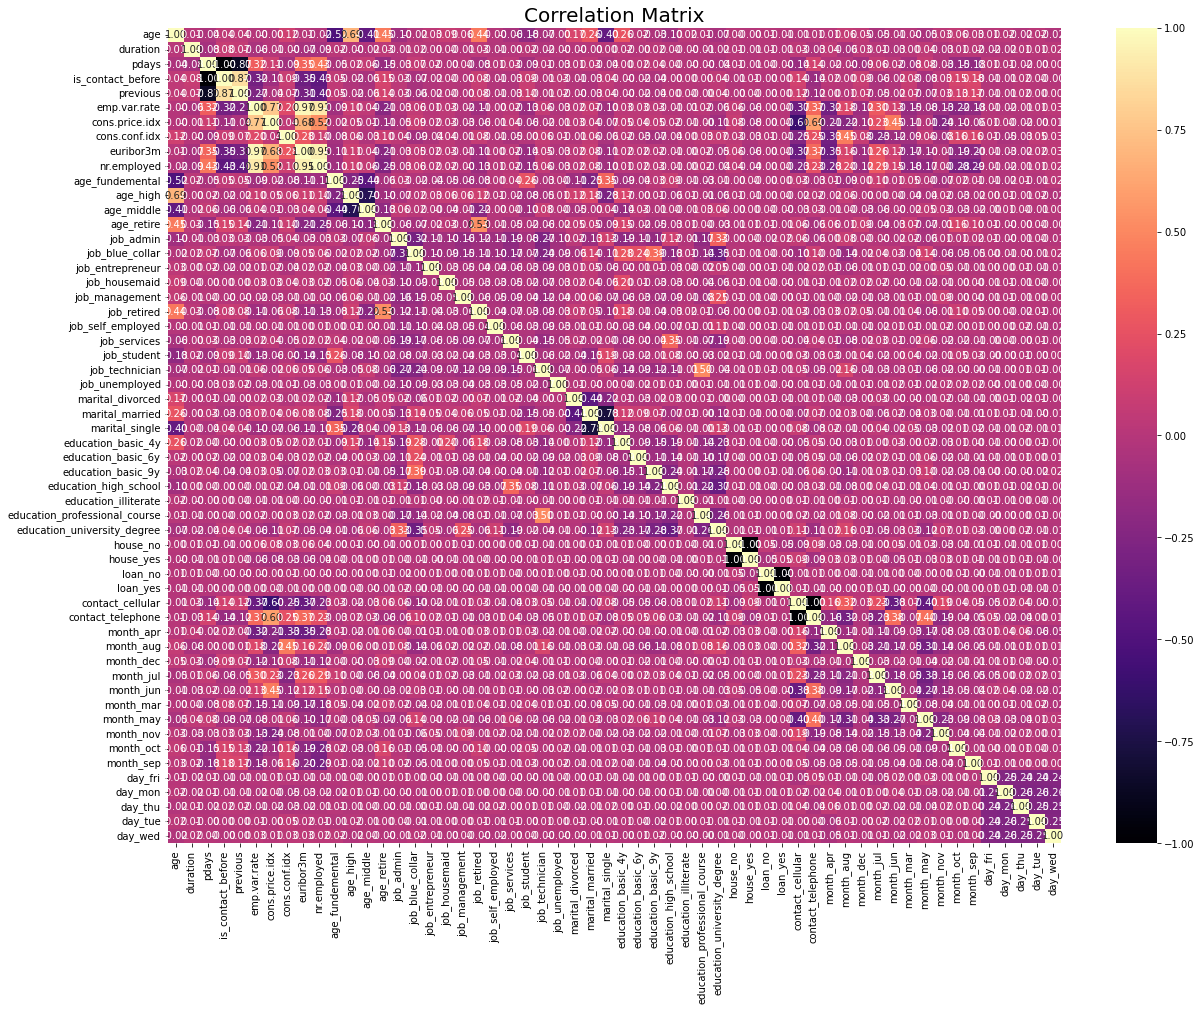

In [18]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(sns_dataset.corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

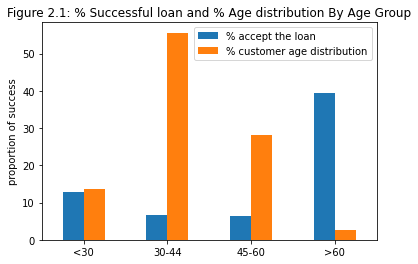

In [19]:
age_y_crosstab = pd.crosstab(final_dataset['y'],final_dataset['age_group']).\
                        apply(lambda x: x/x.sum() * 100, axis = 0)
cols = list(age_y_crosstab)
cols.insert(1, cols.pop(cols.index('Middle')))
age_y_crosstab = age_y_crosstab.loc[:, cols]
target = age_y_crosstab.loc['yes', ]
customers_age = pd.DataFrame(final_dataset['age_group'].value_counts())
customers_age['age_group'] = customers_age['age_group'] * 100 / customers_age['age_group'].sum()
age_yes_df = pd.concat([target, customers_age], axis = 1)
age_yes_df.columns = ['% accept the loan', '% customer age distribution']
age_yes_df.plot(kind = 'bar')
plt.ylabel('proportion of success')
plt.title('Figure 2.1: % Successful loan and % Age distribution By Age Group')
plt.xticks(np.arange(4), ('<30', '30-44', '45-60', '>60'), rotation = 'horizontal')
plt.show()

**Figure 2.1** shows the proportion of the customers accepting the loan grouped by Age and the distribution of age group in the whole dataset. As our imagine, older people will be more likely to allocate the assets in the low risky investment tools, in this case our loan, which cause the percentage of the successful response of older people is much higher than that of middle-aged people. However, the distribution of the age group in the dataset suggests that the bank put more focus on the middle-aged people (age 30 – 60), which may potentially miss the chance in the 60+ customers.

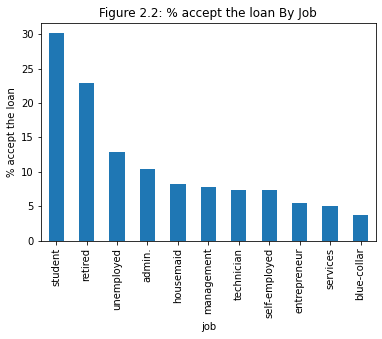

In [20]:
job_y_crosstab = pd.crosstab(final_dataset['y'],final_dataset['job']).apply(lambda x: x/x.sum() * 100)
job_y_crosstab = job_y_crosstab.T.sort_values(by = 'yes', ascending = False)['yes'].plot(kind = 'bar')
plt.title('Figure 2.2: % accept the loan By Job')
plt.ylabel('% accept the loan')
plt.show()

**Figure 2.2** shows the percentages of successful response grouped by job. This figure shows the similar pattern as 5.1 shows. Since **students** are the majority of the age < 30 and people whose age > 60 are most likely **retired** from the jobs. The percentage of successful response of student and retired people is more than 50%, which indicates potential high profits from these people groups.

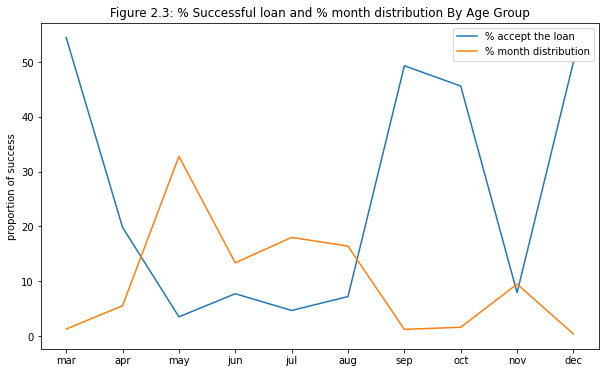

In [21]:
month_y_crosstab = pd.crosstab(final_dataset['y'],final_dataset['month']).\
                        apply(lambda x: x/x.sum() * 100, axis = 0)

cols = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_y_crosstab = month_y_crosstab.loc[:, cols]
target = month_y_crosstab.loc['yes', ]
customers_age = pd.DataFrame(final_dataset['month'].value_counts())
customers_age['month'] = customers_age['month'] * 100 / customers_age['month'].sum()
age_yes_df = pd.concat([target, customers_age], axis = 1)
age_yes_df.columns = ['% accept the loan', '% month distribution']
age_yes_df.plot(figsize = (10,6))
plt.ylabel('proportion of success')
plt.title('Figure 2.3: % Successful loan and % month distribution By Age Group')
plt.xticks(np.arange(10), cols)
plt.show()

Due to some data collecting reasons, our dataset missed the data of Jan and Feb, so we draw the figure 2.3 to see whether the successful response is related to the month effect. The blue line shows the percentage of successful response over each month and the orange line shows the distribution of the calls over each month. As the figure shows, the bank made the phone mainly in the summer, **from May to August**. However, although there are few calls, the perception of successful responses is high in **Mar, September October and December**, which may potentially show that the response of loan may have the month effects and the bank may decide an inappropriate timing of marketing campaign.

## Model Building

In order to evaluate the performance of the models, we use stratified method to split the dataset into **80%** training set and **20%** test set. We will check the classification models’ performance by **accuracy, precision, recall, F1-score, ROC curve and AUROC score**. We use the most popular and common algorithms with that is used in learning activities in the area of data mining. The model contains:

1. **Logistic Regression**: a statistical model for classifying the success/fail classes. Logistic regression classifies binary labels like Yes/No. In our dataset, most of the variables are dummies, so it is adaptive to use this probabilistic model to fit the data. The withdraw of the model is that it could not learn the high-dimension cross features information from the dataset.

2. **Decision Tree**: a tree structure model working on classification based on entropy and information gain. The outliers may cause the model not so stable, which is may cause the performance of the model not so good.

3. **Random Forest**: a combination of hundreds or thousands of decision trees training each one on separately and prediction are made by averaging of them. As the ensemble of the decision tree, Random Forest is not sensitive to outliers and may learn the high-dimension features of the dataset, so it may have a better performance.

4. **Support Vector Machine**: a model applied for classification and divide the dataset into classes to predict whether a new example falls into one category or other.

5. **Gaussian Naïve Bayes**: a classification model based on the Bayes theorem. This model may not so apply to our dataset since some of our features are not so like in Bayes distribution, but it still could perform well in non-Bayes distribution dataset.

5. **Gradient Boosting**: a boosting classification model based. It will use weak classifier to update the error on the reverse direction of the max gradient in the last step. And predict the result based on all the these stacked classifiers.

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, dataset_y, test_size = 0.2, stratify = dataset_y)
train_result = []
test_result = []
scoring = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']
result_list = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']
model_names = ['GausNB', 'DT', 'LR', 'SVM', 'RF', 'GB']

model_fit = [GaussianNB(), DecisionTreeClassifier(), LogisticRegression(), SVC(), RandomForestClassifier(), GradientBoostingRegressor()]
result = []


In [94]:
for model_index in range(6):
    train_sub_result = []
    test_sub_result = []
    if model_index == 3:
        sub_model = SVC(probability = True)
    else:
        sub_model = model_fit[model_index]
    sub_model.fit(X_train, Y_train)
    test_prediction = sub_model.predict(X_test)
    train_prediction =  sub_model.predict(X_train)
    test_accuracy = accuracy_score(Y_test, (test_prediction > 0.5))
    train_accuracy = accuracy_score(Y_train, (train_prediction > 0.5))
    test_f1 = f1_score(Y_test, (test_prediction > 0.5))
    train_f1 = f1_score(Y_train, (train_prediction > 0.5))
    test_precision = precision_score(Y_test, (test_prediction > 0.5))
    train_precision = precision_score(Y_train, (train_prediction > 0.5))
    test_recall = recall_score(Y_test, (test_prediction > 0.5))
    train_recall = recall_score(Y_train, (train_prediction > 0.5))
    test_roc = roc_auc_score(Y_test, test_prediction)
    train_roc = roc_auc_score(Y_train, train_prediction)
    
    train_result.append([train_accuracy, train_precision, train_recall, train_f1, train_roc])
    test_result.append([test_accuracy, test_precision, test_recall, test_f1, test_roc])
    print('model ' + model_names[model_index] + ' completed')


model GausNB completed
model DT completed
model LR completed
model SVM completed
model RF completed
model GB completed


In [95]:
col_name = []
for i in result_list:
    col_name.append(i[5:])
res = pd.DataFrame(test_result, columns = pd.MultiIndex.from_product([['Evaluation Metrics of Classification Models on test set'], col_name]), index = model_names)
res.index.name = 'Classification Models'
res

Evaluation Metrics of Classification Models on test set  \
                                                                      ccuracy   
Classification Models                                                           
GausNB                                                          0.904197        
DT                                                              0.913894        
LR                                                              0.935462        
SVM                                                             0.928942        
RF                                                              0.937803        
GB                                                              0.939977        

                                                               
                       recision     ecall         1    oc_auc  
Classification Models                                          
GausNB                 0.436187  0.546559  0.485175  0.741477  
DT                     0.478873  0.481781  0.480323  0.717289  
LR                     0.676471  0.419028  0.517500  0.700493  
SVM                    0.637450  0.323887  0.429530  0.653651  
RF                     0.675287  0.475709  0.558195  0.727557  
GB                     0.689076  0.497976  0.578143  0.949556

In [96]:
col_name = []
for i in result_list:
    col_name.append(i[5:])
res = pd.DataFrame(train_result, columns = pd.MultiIndex.from_product([['Evaluation Metrics of Classification Models on train set'], col_name]), index = model_names)
res.index.name = 'Classification Models'
res

Evaluation Metrics of Classification Models on train set  \
                                                                      accuracy   
Classification Models                                                            
GausNB                                                          0.909543         
DT                                                              1.000000         
LR                                                              0.936505         
SVM                                                             0.927183         
RF                                                              1.000000         
GB                                                              0.946871         

                                                               
                      precision    recall        f1   roc_auc  
Classification Models                                          
GausNB                 0.460084  0.554711  0.502986  0.748083  
DT                     1.000000  1.000000  1.000000  1.000000  
LR                     0.680127  0.435157  0.530738  0.708375  
SVM                    0.618126  0.307497  0.410690  0.645206  
RF                     1.000000  1.000000  1.000000  1.000000  
GB                     0.743590  0.543566  0.628036  0.963784

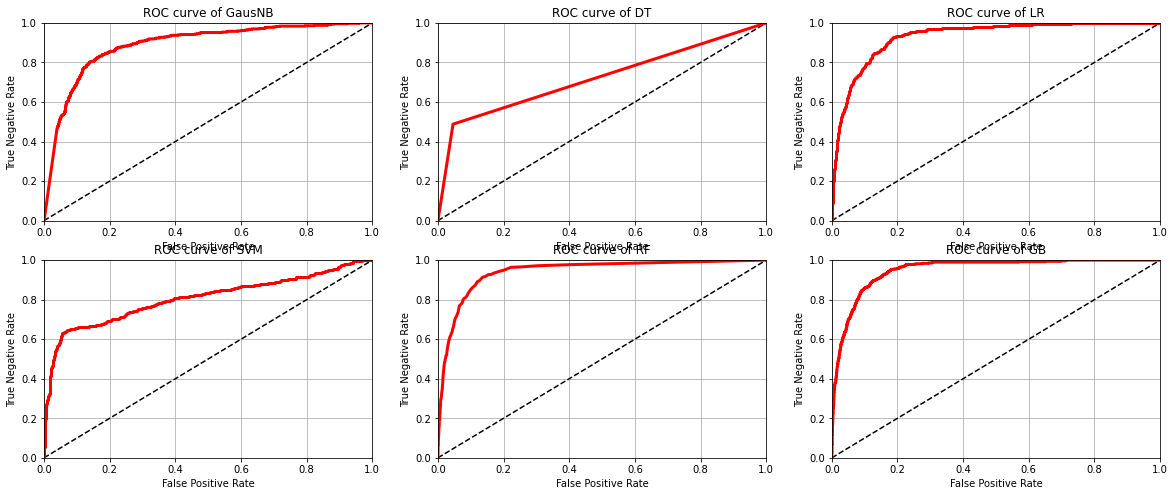

In [98]:
plt.figure(figsize=(20, 8))
for model_index in range(6):
    plt.subplot(2, 3, model_index + 1)
    if model_index == 3:
        sub_model = SVC(probability = True)
    else:
        sub_model = model_fit[model_index]
    sub_model.fit(X_train, Y_train)
    if model_index < 5:
        prediction = sub_model.predict_proba(X_test)[:, 1]
    else:
        prediction = sub_model.predict(X_test)
    fpr, tpr, _ = roc_curve(Y_test, prediction)
    aucval = auc(fpr, tpr)    # 计算auc的取值
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr,"r",linewidth = 3)
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    model_name = model_names[model_index]
    plt.title("ROC curve of " + model_name)
plt.savefig('ROC.png')
plt.show()

**Gradient Boosting** above all give the better results with %94.00 accuracy, %57.81 F1-score and %94.96 AUROC Score among five models compared to other models on the test set. Random Forest has almost similar metrics of Gradient Boosting. The accuracy is %93.78, F1-score is %55.82. 

Due to the highly **unbalanced** distribution of success/fail cases in the dataset, the Scores may be a little biased, and there is a need for stratified sampling or rebalancing to deal with this unbalanced structure of dataset. This leads to a good accuracy even on prediction of a near constant label however the F1-score becomes low.

In term of this, we try some methods to solve this problem. One is **SMOTE** algorithm, which is the popular used resampling method. It is an over-sampling method to deal with the unbalanced dataset. It will forge the class with less number in the dataset by searching the k-nearest point near each point of them. Then the algorithm will randomly produce the fake-samples between the line in the feature space. In our experiment, we will use SMOTE to resample the train set to get 70% train set and 30% test set, then after we create models, we calculate the performance on the test set.


In [112]:
over_samples = SMOTE(random_state = 1234, sampling_strategy = 3 / 7)
over_samples_X, over_samples_y = over_samples.fit_resample(X_train, Y_train)
train_result_over = []
test_result_over = []
for model_index in range(6):
    train_sub_result_over = []
    test_sub_result_over = []
    if model_index == 3:
        sub_model = SVC(probability = True)
    else:
        sub_model = model_fit[model_index]
    sub_model.fit(over_samples_X, over_samples_y)
    test_prediction = sub_model.predict(X_test)
    train_prediction =  sub_model.predict(over_samples_X)
    test_accuracy = accuracy_score(Y_test, (test_prediction > 0.5))
    train_accuracy = accuracy_score(over_samples_y, (train_prediction > 0.5))
    test_f1 = f1_score(Y_test, (test_prediction > 0.5))
    train_f1 = f1_score(over_samples_y, (train_prediction > 0.5))
    test_precision = precision_score(Y_test, (test_prediction > 0.5))
    train_precision = precision_score(over_samples_y, (train_prediction > 0.5))
    test_recall = recall_score(Y_test, (test_prediction > 0.5))
    train_recall = recall_score(over_samples_y, (train_prediction > 0.5))
    test_roc = roc_auc_score(Y_test, test_prediction)
    train_roc = roc_auc_score(over_samples_y, train_prediction)
    
    train_result_over.append([train_accuracy, train_precision, train_recall, train_f1, train_roc])
    test_result_over.append([test_accuracy, test_precision, test_recall, test_f1, test_roc])
    print('model ' + model_names[model_index] + ' completed')

model GausNB completed
model DT completed
model LR completed
model SVM completed
model RF completed
model GB completed


In [117]:
col_name = []
for i in result_list:
    col_name.append(i[5:])
res = pd.DataFrame(train_result_over, columns = pd.MultiIndex.from_product([['Evaluation Metrics of Classification Models on over sampling train set'], col_name]), index = model_names)
res.index.name = 'Classification Models'
res

Evaluation Metrics of Classification Models on over sampling train set  \
                                                                                    accuracy   
Classification Models                                                                          
GausNB                                                          0.837059                       
DT                                                              1.000000                       
LR                                                              0.864647                       
SVM                                                             0.848445                       
RF                                                              1.000000                       
GB                                                              0.953692                       

                                                               
                      precision    recall        f1   roc_auc  
Classification Models                                          
GausNB                 0.804191  0.603870  0.689781  0.770430  
DT                     1.000000  1.000000  1.000000  1.000000  
LR                     0.793229  0.742292  0.766916  0.829686  
SVM                    0.811013  0.645120  0.718617  0.790349  
RF                     1.000000  1.000000  1.000000  1.000000  
GB                     0.931719  0.912503  0.922011  0.990358

In [116]:
col_name = []
for i in result_list:
    col_name.append(i[5:])
res = pd.DataFrame(test_result_over, columns = pd.MultiIndex.from_product([['Evaluation Metrics of Classification Models on over sampling test set'], col_name]), index = model_names)
res.index.name = 'Classification Models'
res

Evaluation Metrics of Classification Models on over sampling test set  \
                                                                                   accuracy   
Classification Models                                                                         
GausNB                                                          0.903193                      
DT                                                              0.911052                      
LR                                                              0.900184                      
SVM                                                             0.906705                      
RF                                                              0.937636                      
GB                                                              0.936131                      

                                                               
                      precision    recall        f1   roc_auc  
Classification Models                                          
GausNB                 0.434716  0.572874  0.494323  0.752903  
DT                     0.462000  0.467611  0.464789  0.709293  
LR                     0.437576  0.730769  0.547384  0.823103  
SVM                    0.453757  0.635628  0.529511  0.783369  
RF                     0.666667  0.489879  0.564761  0.733913  
GB                     0.618644  0.591093  0.604555  0.947107

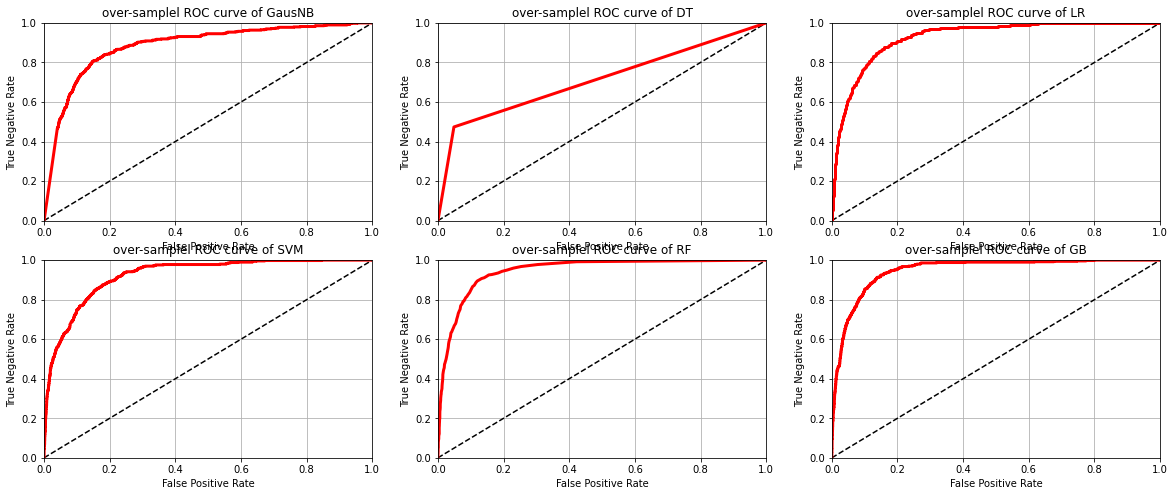

In [115]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(20, 8))
for model_index in range(6):
    plt.subplot(2, 3, model_index + 1)
    if model_index == 3:
        sub_model = SVC(probability = True)
    else:
        sub_model = model_fit[model_index]
    sub_model.fit(over_samples_X, over_samples_y)
    if model_index < 5:
        prediction = sub_model.predict_proba(X_test)[:, 1]
    else:
        prediction = sub_model.predict(X_test)
    fpr, tpr, _ = roc_curve(Y_test, prediction)
    aucval = auc(fpr, tpr)    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr,"r",linewidth = 3)
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    model_name = model_names[model_index]
    plt.title("over-samplel ROC curve of " + model_name)
plt.savefig('ROC-over.png')
plt.show()

**Gradient Boosting** still performed the best among five models in the test set, which get %60.46 f1 score and  %61.86 precision. However, although we can see that the recall score is higher after the over-sampling, the f1-score did not increase a lot. This may be because most of the variables in the dataset are dummies and it is little useful to create the point between 0 and 1 in the feature space, which implies that SMOTE may not forge very informatic samples. 

In [118]:
under_model = RandomUnderSampler(sampling_strategy = 3 / 7)
x_under, y_under = under_model.fit_resample(X_train, Y_train)
train_result_under = []
test_result_under = []
for model_index in range(6):
    train_sub_result_under = []
    test_sub_result_under = []
    if model_index == 3:
        sub_model = SVC(probability = True)
    else:
        sub_model = model_fit[model_index]
    sub_model.fit(x_under, y_under)
    test_prediction = sub_model.predict(X_test)
    train_prediction =  sub_model.predict(x_under)
    test_accuracy = accuracy_score(Y_test, (test_prediction > 0.5))
    train_accuracy = accuracy_score(y_under, (train_prediction > 0.5))
    test_f1 = f1_score(Y_test, (test_prediction > 0.5))
    train_f1 = f1_score(y_under, (train_prediction > 0.5))
    test_precision = precision_score(Y_test, (test_prediction > 0.5))
    train_precision = precision_score(y_under, (train_prediction > 0.5))
    test_recall = recall_score(Y_test, (test_prediction > 0.5))
    train_recall = recall_score(y_under, (train_prediction > 0.5))
    test_roc = roc_auc_score(Y_test, test_prediction)
    train_roc = roc_auc_score(y_under, train_prediction)
    
    train_result_under.append([train_accuracy, train_precision, train_recall, train_f1, train_roc])
    test_result_under.append([test_accuracy, test_precision, test_recall, test_f1, test_roc])
    print('model ' + model_names[model_index] + ' completed')

model GausNB completed
model DT completed
model LR completed
model SVM completed
model RF completed
model GB completed


In [120]:
col_name = []
for i in result_list:
    col_name.append(i[5:])
res = pd.DataFrame(train_result_under, columns = pd.MultiIndex.from_product([['Evaluation Metrics of Classification Models on under sampling train set'], col_name]), index = model_names)
res.index.name = 'Classification Models'
res

Evaluation Metrics of Classification Models on under sampling train set  \
                                                                                     accuracy   
Classification Models                                                                           
GausNB                                                          0.830395                        
DT                                                              1.000000                        
LR                                                              0.864438                        
SVM                                                             0.827660                        
RF                                                              1.000000                        
GB                                                              0.908815                        

                                                               
                      precision    recall        f1   roc_auc  
Classification Models                                          
GausNB                 0.809971  0.567882  0.667659  0.755392  
DT                     1.000000  1.000000  1.000000  1.000000  
LR                     0.790548  0.745694  0.767466  0.830511  
SVM                    0.873002  0.497974  0.634194  0.733464  
RF                     1.000000  1.000000  1.000000  1.000000  
GB                     0.839092  0.861196  0.850000  0.969971

In [121]:
col_name = []
for i in result_list:
    col_name.append(i[5:])
res = pd.DataFrame(test_result_under, columns = pd.MultiIndex.from_product([['Evaluation Metrics of Classification Models on under sampling test set'], col_name]), index = model_names)
res.index.name = 'Classification Models'
res

Evaluation Metrics of Classification Models on under sampling test set  \
                                                                                    accuracy   
Classification Models                                                                          
GausNB                                                          0.903862                       
DT                                                              0.882461                       
LR                                                              0.898512                       
SVM                                                             0.926434                       
RF                                                              0.906705                       
GB                                                              0.896338                       

                                                               
                      precision    recall        f1   roc_auc  
Classification Models                                          
GausNB                 0.435816  0.556680  0.488889  0.745900  
DT                     0.389884  0.748988  0.512821  0.821733  
LR                     0.434072  0.753036  0.550703  0.832323  
SVM                    0.558190  0.524291  0.540710  0.743465  
RF                     0.464045  0.836032  0.596821  0.874550  
GB                     0.433544  0.831984  0.570042  0.948222

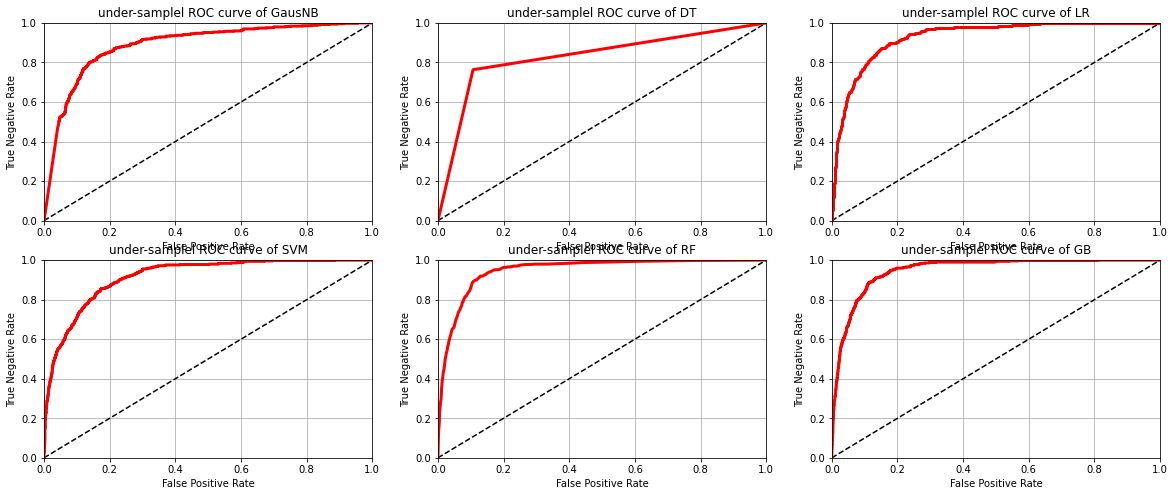

In [122]:
plt.figure(figsize=(20, 8))
for model_index in range(6):
    plt.subplot(2, 3, model_index + 1)
    if model_index == 3:
        sub_model = SVC(probability = True)
    else:
        sub_model = model_fit[model_index]
    sub_model.fit(x_under, y_under)
    if model_index < 5:
        prediction = sub_model.predict_proba(X_test)[:, 1]
    else:
        prediction = sub_model.predict(X_test)
    fpr, tpr, _ = roc_curve(Y_test, prediction)
    aucval = auc(fpr, tpr)    # 计算auc的取值
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr,"r",linewidth = 3)
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Negative Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    model_name = model_names[model_index]
    plt.title("under-samplel ROC curve of " + model_name)
plt.savefig('under-over.png')
plt.show()

Also, we try **Random under-sampling** to the dataset, which means that we throw some failure cases to balance the dataset. This method may have the implied risk that it may drop some information from the training set and may worsen the performance at last. We deduct the failure cases and make the proportion of failure: success = 7:3. The result is shown in table 3.4. 

Still, the **Random Forest** get the better performance than others, which get %57.00 f1-score and %83.60 recall. This time, the recall scores on the test set increase a lot, at the expense of the precision score. The f1-score did not increase a lot, which means that the under-sampling may be have a little effective, but problem of unbalancing still exists.

## Important Features

Above all, we could see that two ensmble learning algorithms **Random Forest** and **Gradient Boosting** performed better than other algorithms. We will use these two methods to see how these features affect the accpted events. Besides, **F1-score** is a balanced scoring metrics for evaluate precision and recall(which is more important for accpted events, but here we just weightly consider them), so we will use F1 score for our scoring metric.

### Random Forest

In [24]:
f1 = make_scorer(f1_score , average='macro')
params = {'max_features': [6, 8, 10],
          'n_estimators': [150, 200]}
rf = RandomForestClassifier()
forest_grid = GridSearchCV(rf, params, cv=5, scoring = f1)
forest_grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring=make_scorer(f1_score, average=macro))

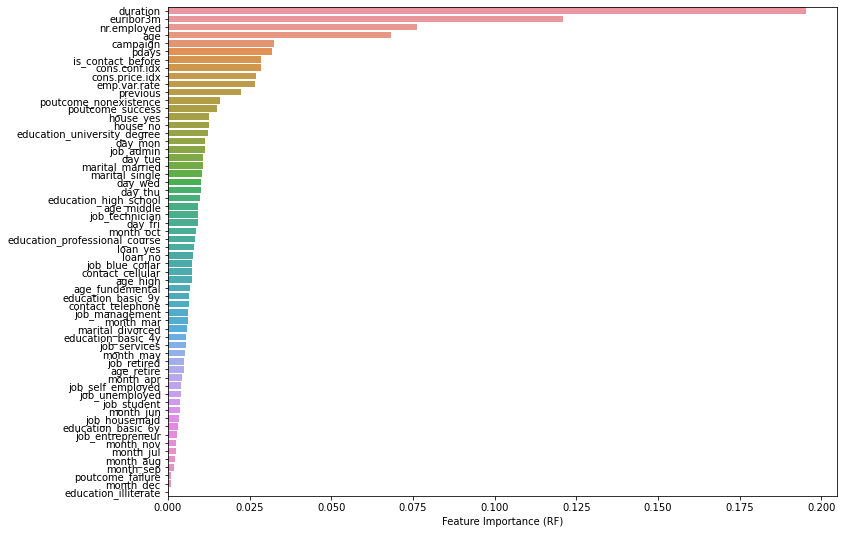

In [25]:
rf_res = pd.DataFrame(forest_grid.best_estimator_.feature_importances_, index = X_train.columns, columns = ['Feature Importance (RF)'])
rf_res = rf_res.sort_values(by = 'Feature Importance (RF)',ascending=False)
rf_sns = sns.barplot(x = "Feature Importance (RF)", y = rf_res.index, data = rf_res)
rf_sns.figure.set_size_inches(12, 9)

In [26]:
rf_res

,Feature Importance (RF)
duration,0.195184
euribor3m,0.121018
nr.employed,0.076286
age,0.068427
campaign,0.032614
pdays,0.031943
is_contact_before,0.028652
cons.conf.idx,0.028580
cons.price.idx,0.026976
emp.var.rate,0.026663


### Gradient Boosting

In [27]:
gb = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10],
          'learning_rate': [0.05, 0.1, 0.5],
          'n_estimators': [150, 200]}

gb_grid = GridSearchCV(gb, params, cv = 5, scoring = f1)
gb_grid.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring=make_scorer(f1_score, average=macro))

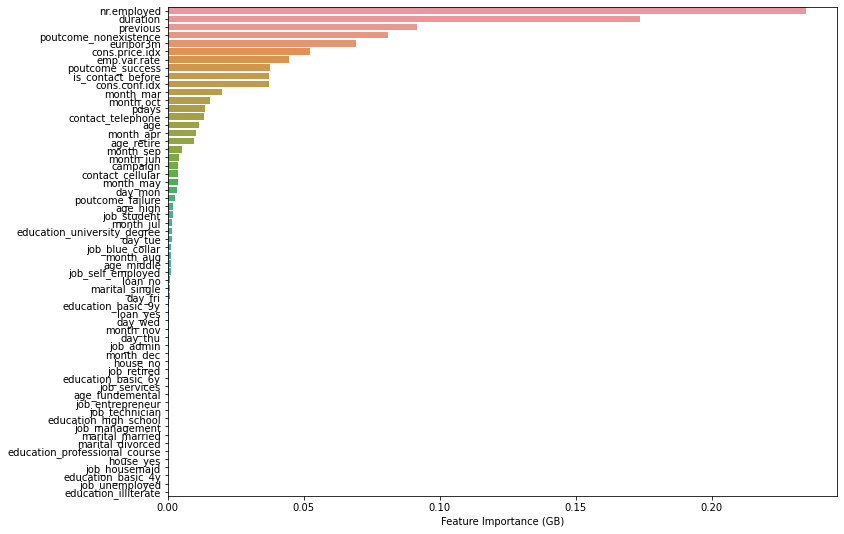

In [28]:
gb_res = pd.DataFrame(gb_grid.best_estimator_.feature_importances_, index = X_train.columns, columns = ['Feature Importance (GB)'])
gb_res = gb_res.sort_values(by = 'Feature Importance (GB)',ascending=False)
gb_sns = sns.barplot(x = "Feature Importance (GB)", y = gb_res.index, data = gb_res)
gb_sns.figure.set_size_inches(12, 9)

In [29]:
gb_res

,Feature Importance (GB)
nr.employed,0.234496
duration,0.173788
previous,0.091735
poutcome_nonexistence,0.080990
euribor3m,0.069296
cons.price.idx,0.052097
emp.var.rate,0.044381
poutcome_success,0.037679
is_contact_before,0.037319
cons.conf.idx,0.037031


### Permutation Importances
Permutation Importance idea is that how if we shuffle the values of one of the features, how it will imporve (or reduce) the scoring of the models on the test set. If the scoring of the model does not change a lot aftering the shuffling, then it means that the feature is useless in predicting the result.

In [36]:
rf_best_ = forest_grid.best_estimator_
PI_n = permutation_importance(rf_best_, X_test, Y_test, n_repeats = 5, random_state = 1)



PI_res = pd.DataFrame(data = np.transpose([PI_n['importances_mean'], PI_n['importances_std']]), 
             index = X_test.columns, columns = ['PI_mean', 'PI_std'])
PI_res = PI_res.sort_values(by = 'PI_mean', ascending = False)
PI_res

,PI_mean,PI_std
duration,2.140110e-02,0.002118
euribor3m,4.447417e-03,0.001107
nr.employed,3.745193e-03,0.000767
emp.var.rate,1.571644e-03,0.000955
pdays,7.022237e-04,0.000125
month_may,5.015884e-04,0.000529
job_retired,4.347099e-04,0.000082
day_fri,3.678315e-04,0.000357
is_contact_before,2.675138e-04,0.000082
previous,2.340746e-04,0.000171


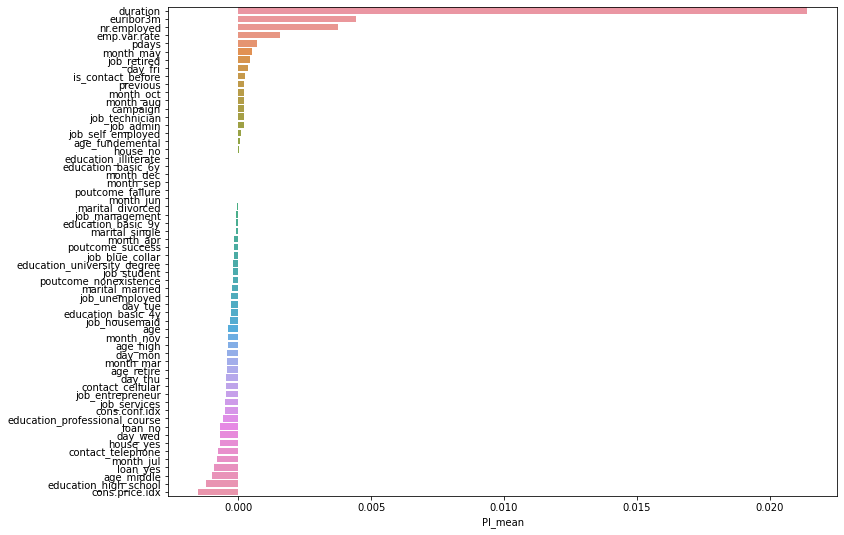

In [31]:
PI_sns = sns.barplot(x = "PI_mean", y = PI_res.index, data = PI_res)
PI_sns.figure.set_size_inches(12, 9)

As we can see, **duration, euribor3m, nr.employed, previous** these features will have great importance for these three method for our prediction of the accpted event. The below is the comparation of the features importance for these three method.

In [32]:
summary = pd.DataFrame({'Random Forest':list(rf_res.index),
              'Gradient Boost':list(gb_res.index),
               'Permutation Importance':list(PI_res.index)})
summary

,Random Forest,Gradient Boost,Permutation Importance
0,duration,nr.employed,duration
1,euribor3m,duration,euribor3m
2,nr.employed,previous,nr.employed
3,age,poutcome_nonexistence,emp.var.rate
4,campaign,euribor3m,pdays
5,pdays,cons.price.idx,month_may
6,is_contact_before,emp.var.rate,job_retired
7,cons.conf.idx,poutcome_success,day_fri
8,cons.price.idx,is_contact_before,is_contact_before
9,emp.var.rate,cons.conf.idx,previous


### SHAP
Although we get the feature importance of these models, we did not know how actually these features will affect the result. SHAP (SHapley Additive exPlanations) is a game-theoretic approach to explain the output of any machine learning model. It Will tell how these features affect the result, on positive side? Or on the negative side? It consider the "marginal contribution" of the features to the prediction when they are added to the model and average them from different combinations of adding, which will finally tell how this feature will affect the model, and the direction of it.

In [33]:
explainer = shap.TreeExplainer(gb_grid.best_estimator_)
shap_values = explainer.shap_values(dataset)


In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[-1, :], dataset.iloc[-1, :])

For example, we get the last case of our dataset, which is a "accpted" case. In our random forest model, **"emp.var.rate, euribor3m, duration, nr.employed"** these features make our model consider that this case is a "accpted" case and predict it as 1. So when emp.var.rate, cons.conf.idx are lower, and euribor3m, duration, nr.employed are higher, the model will be more likely to forcast this case as "accpted".

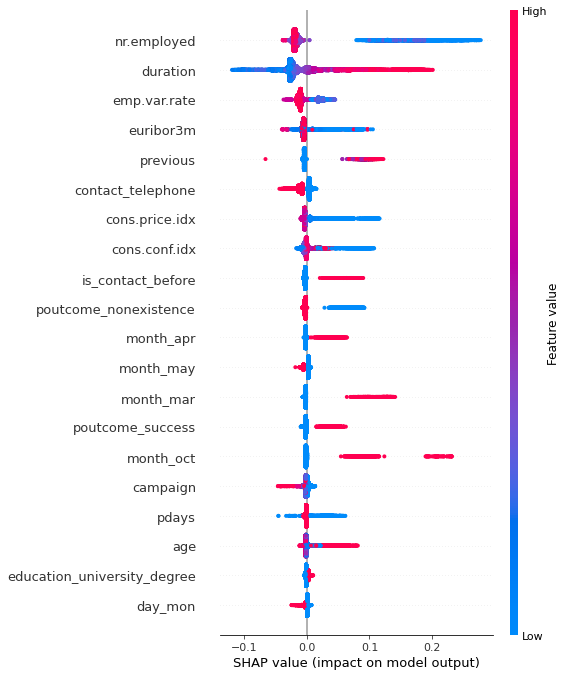

In [35]:
shap.summary_plot(shap_values, dataset)

The horizontal axis means the SHAP value for each case and each feature. The red part means "high feature value" while the blue part means "low feature value". For example, for Duration, the red part has a relatively high SHAP value. This means when the duration is high, the SHAP value of it is high and high duration means the "accept rate" for this case is also high. As we can see, low nr.employed, duration, euribor3m, previous may have a relatively large affect on the prediction. We calculate the absolute mean SHAP values for these features and get the SHAP feature importance for the random forest as below.

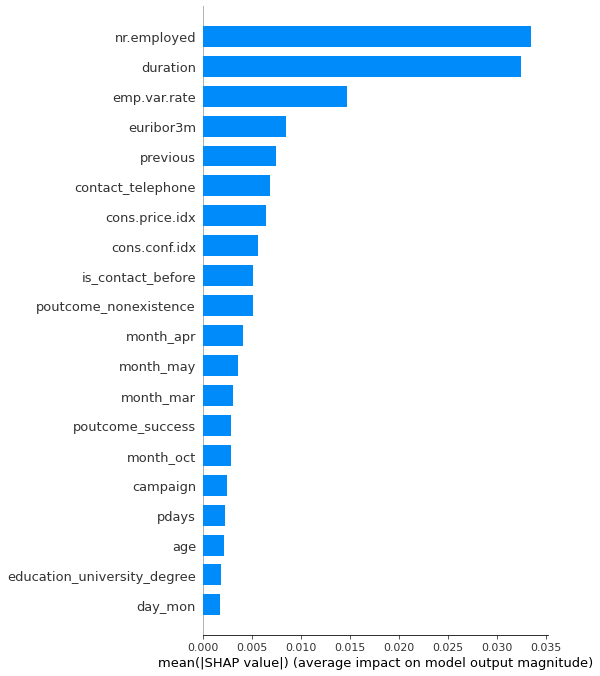

In [37]:
shap.summary_plot(shap_values, dataset, plot_type = "bar")

## Obversation and Conclusion

* The main target of this report is to analyze the dataset from Portuguese bank in order to improve the effectiveness of the bank’s telephone campaign. In the data visualization part, we found that age 60+ people, who are mostly retired people, and age 29- people, who are mostly students are the most responsive customers, which may need the bank to set more focus on them and make more calls and preferential to attract them. That may help the bank get more potential profits. Besides, the bank may change the major timing of call campaign to winter, such as September and October. The potential month effect of loan response may help the bank get more successful deposit. 

* As for the model selection, six algorithms (Gaussian Naïve Bayes, Decision Tree, Logistic Regression, SVM, Random Forest and Gradient Boosting) were applied. Among them, the Random Forest Classifier has the advanced performance, therefore could be used as the final model to help accelerate the telemarking campaign opportunity and help the bank wasting less time on the potentially failure customers and increase the bank’s earning capacity. However, due to the unbalanced structure of the dataset, the performance is not so excellent. We have tried SMOTE and Random under sampling methods to resampling the dataset, but the performance is still not so ideal. Maybe there need more technologies and more accurate information to help us improve the performance of the models
